<a href="https://colab.research.google.com/github/davidandres8/Ejercicios/blob/master/regresionMulti_MLvalpo_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Effective Temperature and Rotational Velocity in Massive Stars
***
**Activity objective**: Use several ML methods to predict the effective temperature and rotational velocity from massive-star spectra.

**Data**: A subset of Be-star spectra generated by PhD candidate Daniela Turis (IFA-UV) using the ZPEKTR code.

When using ML, this problem is addressed as a **multi-output regression** task.

More information about massive stars: https://massivestars.ifa.uv.cl/


## Python Libraries
***

In [1]:
import os
import sys

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import numpy as np
import time


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Custom functions


***

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import matplotlib.pyplot as plt

def plot_spectrum(wavelengths, flux, title="Spectrum", figsize=(10,5)):
    """
    Plot a stellar spectrum using an astrophysics-style dark theme.

    Parameters
    ----------
    wavelengths : array-like
        Array of wavelength values (x-axis).
    flux : array-like
        Flux values (y-axis).
    title : str
        Title of the plot.
    figsize : tuple
        Figure size.
    """

    plt.style.use("dark_background")

    plt.figure(figsize=figsize)

    plt.plot(wavelengths,
             flux,
             color="cyan",
             linewidth=1.8)

    plt.title(title, fontsize=14, color="white")
    plt.xlabel("Wavelength [Å]", fontsize=12, color="white")
    plt.ylabel("Flux", fontsize=12, color="white")

    # Grid tenue
    plt.grid(color="gray", alpha=0.3, linestyle="--")

    # Quitar bordes superiores y derechos
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


def plot_results(y_test, y_pred):
    plt.style.use("seaborn-v0_8-whitegrid")
    targets = ["T_eff", "v sin i"]

    # Reporte de métricas
    for i, target in enumerate(targets):
        print(f"{target} – Linear Regression")
        print(f"  MSE: {mean_squared_error(y_test.values[:, i], y_pred[:, i]):.2f}")
        print(f"  MAE: {mean_absolute_error(y_test.values[:, i], y_pred[:, i]):.2f}")
        print(f"  R²:  {r2_score(y_test.values[:, i], y_pred[:, i]):.3f}\n")

    # Visualización conjunta
    plt.figure(figsize=(12, 5))  # más ancho que alto

    for i, target in enumerate(targets):
        plt.subplot(1, 2, i+1)
        sns.scatterplot(x=y_test.values[:, i], y=y_pred[:, i], alpha=0.4)
        plt.plot(
            [y_test.values[:, i].min(), y_test.values[:, i].max()],
            [y_test.values[:, i].min(), y_test.values[:, i].max()],
            'r--'
        )
        plt.xlabel(f"True {target}")
        plt.ylabel(f"Predicted {target}")
        plt.title(f"{target} – Linear Regression")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


## Data Download and Pandas
***
* Data generated with ZPEKTR by PhD candidate Daniela Turis (IFA-UV).
* You should obtain the spectrum dataset named: `df_ZPEKTR_limb_lineal.csv`


In [3]:
# Dataset provided by PhD (c) Daniela Turis, IFA-UV.

# Check if you are running in Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # En Colab, usamos gdown
    import gdown
    !gdown https://drive.google.com/uc?id=1m_GajQqDRcKrH8_ExG_0Yp_sQ4MrhZbN
    data=pd.read_csv("df_ZPEKTR_limb_lineal.csv")

else:
    # In a local environment, load from disk
    file_path = "/Users/rpezoa/Downloads/df_ZPEKTR_limb_lineal.csv"
    if os.path.exists(file_path):
        print("Archivo cargado localmente:", file_path)
        data=pd.read_csv(file_path)

    else:
        print("No se encontró el archivo local. Debes descargarlo manualmente.")


Downloading...
From: https://drive.google.com/uc?id=1m_GajQqDRcKrH8_ExG_0Yp_sQ4MrhZbN
To: /content/df_ZPEKTR_limb_lineal.csv
100% 19.1M/19.1M [00:00<00:00, 201MB/s]


## Inspect the data
---
* Examine the dataset to see how many columns it has and the column names.
* The parameters we will predict are `<Teff>` and `vsini`.
* You may use functions such as: `data.columns`, `data.info()`, `data.describe()`, `data["vsini"].mean()`, etc.


In [4]:
data.head()

,4460.1,4460.2,4460.3,4460.4,4460.5,4460.6,4460.7,4460.8,4460.9,4461.0,...,vsini,M/M⊙,R/R⊙,V/Vc,L*,Ω/Ωc,Tpole,Teq,gpole,geq
0,0.996583,0.996529,0.996452,0.996362,0.996264,0.996160,0.996052,0.995942,0.995830,0.995717,...,228.0,15.0,5.79,0.75,4.105,0.912,28000.0,23690.0,4.20,4.02
1,0.996234,0.996208,0.996180,0.996141,0.996108,0.996074,0.996027,0.995962,0.995851,0.995678,...,309.0,17.0,5.75,0.77,4.230,0.928,30000.0,25014.0,4.25,4.06
2,0.997128,0.996958,0.996770,0.996573,0.996368,0.996163,0.995957,0.995746,0.995530,0.995321,...,254.0,10.0,8.42,0.65,3.857,0.836,19000.0,16859.0,3.63,3.50
3,0.993683,0.993541,0.993413,0.993277,0.993126,0.992986,0.992836,0.992683,0.992531,0.992366,...,351.0,12.0,5.31,0.68,3.351,0.860,18000.0,15772.0,4.12,3.98
4,0.995026,0.994887,0.994749,0.994607,0.994464,0.994324,0.994183,0.994040,0.993885,0.993727,...,310.0,12.0,6.35,0.65,3.778,0.842,21000.0,18578.0,3.96,3.83


In [15]:
data["vsini"]

,vsini
0,228.0
1,309.0
2,254.0
3,351.0
4,310.0
...,...
10686,181.0
10687,220.0
10688,329.0
10689,346.0


### Generating matrices formatted for use in ML models
***
* When working with tabular data, it is common to create a matrix $X$ for the input data and a matrix $y$ for the outputs.
* Here, $X$ contains the $n = 10691$ spectra, and $y$ contains the $n$ output values or labels for each spectrum. In this case, $y$ will include the effective temperature and the rotational velocity (vsini).


In [13]:
X = data.iloc[:,0:170] # X matrix containing the flux of the spectral lines
y_input = data.iloc[:,170:176] # input parameters of ZPEKTR
y_output = data.iloc[:,176:] # output parameters of ZPEKTR
y = data[["<Teff>", "vsini"]] # y matrix containing the values we want to predict

In [14]:
y

,<Teff>,vsini
0,25502.0,228.0
1,27478.0,309.0
2,18315.0,254.0
3,17238.0,351.0
4,20154.0,310.0
...,...,...
10686,17656.0,181.0
10687,26995.0,220.0
10688,20213.0,329.0
10689,20104.0,346.0


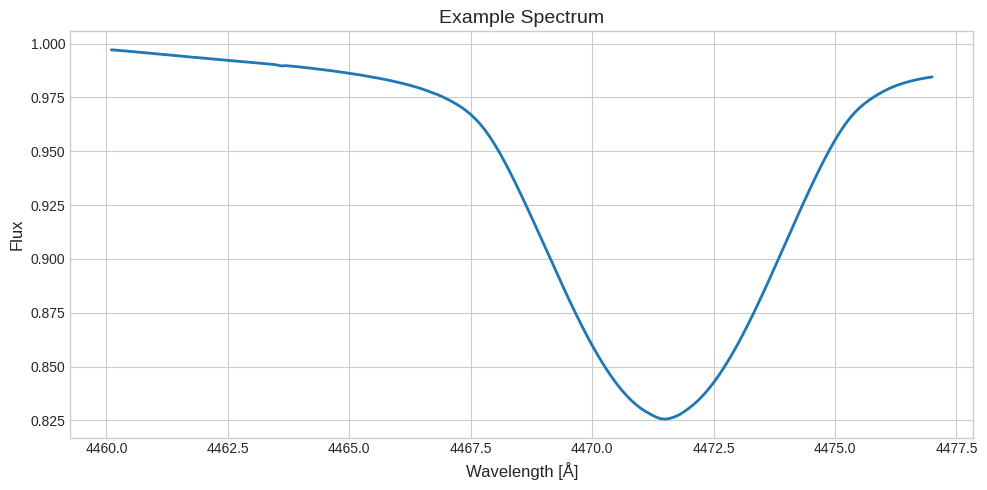

In [16]:
wavelengths = np.array(data.columns[:-18]).astype(float)
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(10,5))
plt.plot(wavelengths, X.iloc[2, :], linewidth=2)

plt.title("Example Spectrum", fontsize=14)
plt.xlabel("Wavelength [Å]", fontsize=12)
plt.ylabel("Flux", fontsize=12)

plt.tight_layout()
plt.show()


### Another type of plot
* Use whichever plot you prefer.

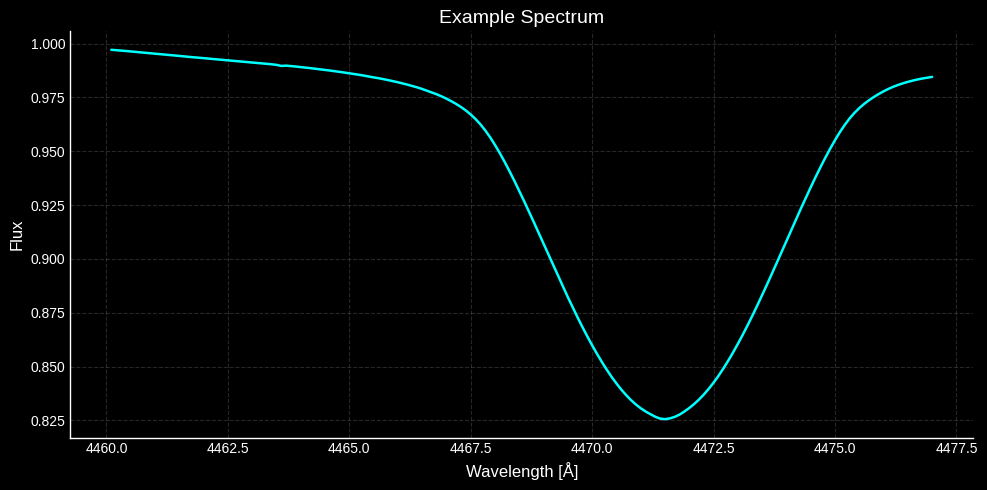

In [17]:

plot_spectrum(wavelengths, X.iloc[2, :], title="Example Spectrum")

### Training, validation, and testing sets
***
* Creating proper training, validation, and testing sets is essential for training and ensuring good generalization of ML models.


In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)

## Machine Learning Models
***
We will use four techniques to predict the effective temperature and rotational velocity:
 * linear regression
 * decision tree
 * random forest
 * gradient boosting


### Linear Regression

* Here we will use the `LinearRegression()` method from scikit-learn.


T_eff – Linear Regression
  MSE: 50993.62
  MAE: 166.14
  R²:  0.997

v sin i – Linear Regression
  MSE: 20.18
  MAE: 3.38
  R²:  0.997



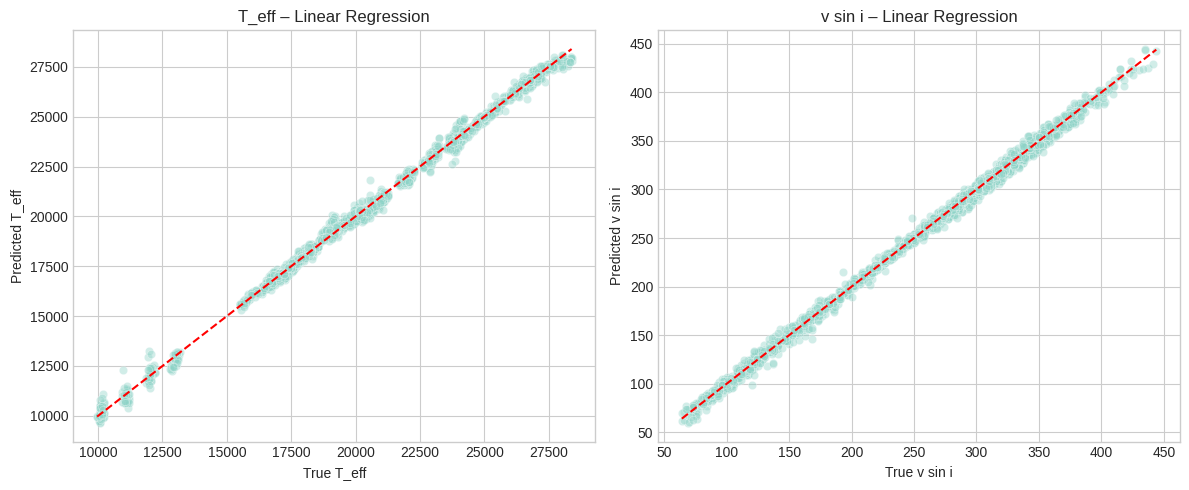

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
plot_results(y_test,y_pred_lr)

### Decision Tree

In [20]:
from sklearn.tree import DecisionTreeRegressor

## Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor

### Hyperparameter Optimization

* Using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from scikit-learn in Python.


In [42]:
param_grid = {
    'n_estimators': [2,4],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [4,5,6,7,8],
    #'criterion' :['gini', 'entropy']
}

rfc= RandomForestRegressor(random_state=42)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=-1)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [2, 4]})

## Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

base_model = GradientBoostingRegressor(n_estimators=10, random_state=42)
model_gb = MultiOutputRegressor(base_model)



In [27]:
base_estimator = GradientBoostingRegressor(random_state=42)

# Wrap it with MultiOutputRegressor
multi_output_model = MultiOutputRegressor(estimator=base_estimator)


param_grid = {
    'estimator__n_estimators': [5,10,20,40],
    'estimator__max_depth': [None, 10, 20]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=multi_output_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

# Now let's test on observed lines
***


## Download observed lines

In [28]:
!gdown
if IN_COLAB:
    # En Colab, usamos gdown
    import gdown
    !gdown https://drive.google.com/uc?id=1WGq1GXOD3SnI985wgMnV7u2NyV3l2BQc
    #!gdown https://drive.google.com/uc?id=1codpDGdi9Z-JjzsJqhu0mxQDCY22XNm5
    #!gdown https://drive.google.com/uc?id=1KQ0mYeRgD_A9u0QyjCMAh1YjakyaE23K
    #!gdown https://drive.google.com/uc?id=1-08NwTp8fFFgCeUj8x9qmg9sfSorZyqt
    df=pd.read_csv("hd60606_4460_4478.dat", header=None,sep=" ")

else:
    # En entorno local, carga desde disco
    file_path = "/Users/rpezoa/repo_temp/mlvalpo/observed_DT/hd60606_4460_4478.dat"
    if os.path.exists(file_path):
        print("Archivo cargado localmente:", file_path)
        df = pd.read_csv(file_path, header=None, sep=" ")

    else:
        print("No se encontró el archivo local. Debes descargarlo manualmente.")

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok] [--format FORMAT]
             [--user-agent USER_AGENT]
             url_or_id
gdown: error: the following arguments are required: url_or_id
Downloading...
From: https://drive.google.com/uc?id=1WGq1GXOD3SnI985wgMnV7u2NyV3l2BQc
To: /content/hd60606_4460_4478.dat
100% 4.40k/4.40k [00:00<00:00, 18.8MB/s]


#### Data labels
| Star | Teff | log g | v sin i |
|---|---|---|---|
| HD 60606 | 19095 ± 656 | 3.94 ± 0.07 | 298 ± 13 |
| HD 212076 | 17374 ± 631 | 3.86 ± 0.15 | 112 ± 8 |
| HD 158427 | 18668 ± 1395 | 4.31 ± 0.15 | 328 ± 15 |
| HD 68980 | 18104 ± 1618 | 3.32 ± 0.33 | 161 ± 13 |



### Brief preprocessing
* Here we will rename the columns, just for clarity.


In [29]:
df.rename(columns={0: 'wavelength', 1:'flux'}, inplace=True)
df.columns

Index(['wavelength', 'flux'], dtype='object')

### Inspect and plot the observed line


In [30]:
df

,wavelength,flux
0,4460.1,0.993958
1,4460.2,0.978906
2,4460.3,0.989185
3,4460.4,0.997934
4,4460.5,1.009590
...,...,...
165,4476.6,1.005332
166,4476.7,1.007919
167,4476.8,1.023256
168,4476.9,1.024781


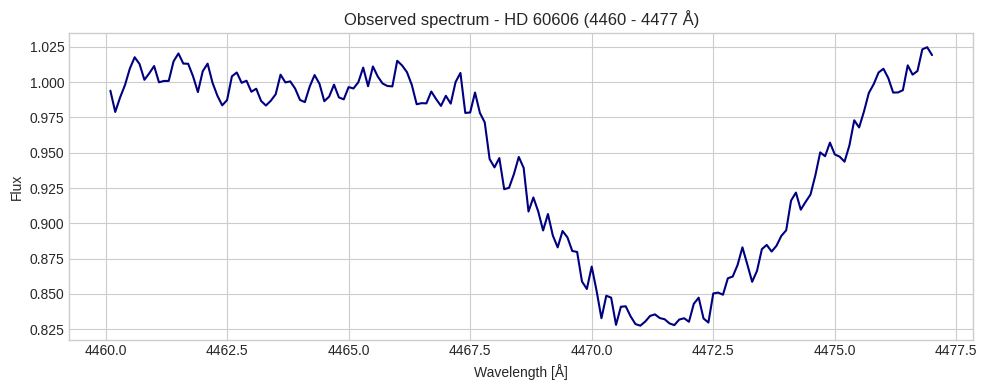

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(df['wavelength'], df['flux'], color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Observed spectrum - HD 60606 (4460 - 4477 Å)")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

In [32]:
espectro_obs  = df["flux"]
espectro_obs = espectro_obs.values.reshape(1,-1)

## Prediction with Linear Regression


In [35]:
model_lr.predict(espectro_obs)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[901200.42727468,  -5278.2442514 ]])

## Prediction with Decision Tree

Decision Tree Results:
MSE: 364946.03
MAE: 334.45
R²: 0.832


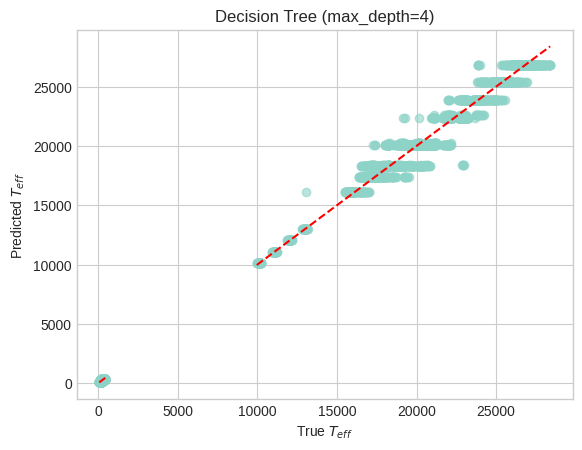

In [39]:
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("Decision Tree Results:")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True $T_{eff}$")
plt.ylabel("Predicted $T_{eff}$")
plt.title("Decision Tree (max_depth=4)")
plt.show()

## Prediction with Random Forest

In [41]:
CV_rfc.best_params_

{'n_estimators': 20}

In [43]:
y_pred_rf = CV_rfc.best_estimator_.predict(X_test)

In [44]:
y_pred_rf

array([[19773.5 ,   266.75],
       [15907.5 ,    83.25],
       [20818.25,   288.75],
       ...,
       [17270.75,   267.25],
       [19116.75,   266.75],
       [16504.25,   124.75]])

T_eff – Linear Regression
  MSE: 35122.41
  MAE: 101.11
  R²:  0.998

v sin i – Linear Regression
  MSE: 72.43
  MAE: 5.59
  R²:  0.990



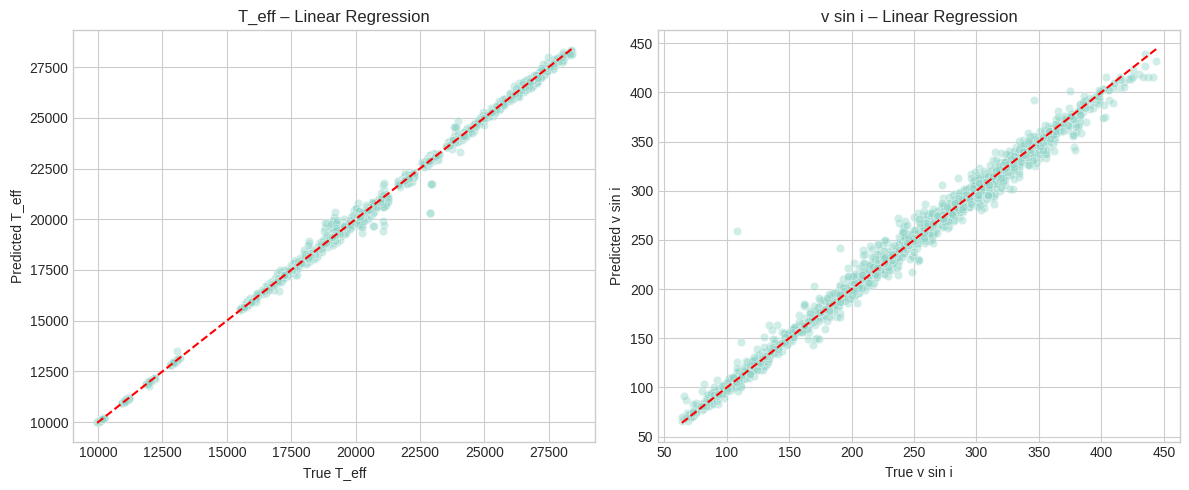

In [45]:
plot_results(y_test,y_pred_rf)

## Predicction with Gradient Boosting

# Questions

1. Analyze the values predicted by each ML method. What happens with the prediction produced by the linear regression technique?

2. How could you improve the results of Gradient Boosting?


In [46]:
CV_rfc.best_estimator_.predict(espectro_obs)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([[16140.25,    99.5 ]])